# (R) 비트코인의 daily/hourly data를 바탕으로

- 거품 측정 (AR(1)의 alpha > 1인지 확인) 및 비트코인이 일반 금융자산이 거품상태일 때와 유사한 양상을 보이는지 확인. 
- GJR-GARCH(1,1)의 gamma 확인 
- 거래량 데이터를 이용해 ARMAX/GARCHX 모델 수립
- daily/hourly data에 따라 차이가 있는지 확인


## 0. Initial settings. 

In [3]:
Sys.setlocale('LC_ALL', 'english')

r = getOption('repos')
r['CRAN'] <- 'http://cran.seoul.go.kr' # 서울시 빅데이터 캠퍼스
options(repos=r)

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

[1] "LC_COLLATE=English_United States.1252;LC_CTYPE=English_United States.1252;LC_MONETARY=English_United States.1252;LC_NUMERIC=C;LC_TIME=English_United States.1252"

In [27]:
require(forecast)
require(zoo)
require(fGarch)
require(rugarch)
require(psych)
require(aTSA)
require(fBasics)
require(tidyverse)
require(dplyr)
require(lubridate)
require(ggplot2)

# 1. Import data and convert to zoo 

In [70]:
all <- read.table("./keypaperdata/all.csv", sep=',', header=TRUE)
head(all)

date,close,vol_usd,mktcap_usd,vol_btc,mktcap_btc,fed_rate,gold_usd,kospi,ex_rate
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2014-01-01,771.40,22489400,9403308145,29154.01,12189925,0.07,1204.50,2011.34,1055.3
2014-01-02,802.39,38489500,9781073921,47968.57,12189925,0.07,1225.00,1967.19,1055.3
2014-01-03,818.72,37810100,9980135396,46181.97,12189925,0.07,1234.50,1946.14,1050.4
2014-01-04,859.51,38005000,10477362437,44217.05,12189925,0.07,1234.50,1946.14,1050.4
2014-01-05,933.53,72898496,11379660685,78089.08,12189925,0.07,1234.50,1946.14,1050.4
2014-01-06,953.29,85565696,11620533603,89758.31,12189925,0.07,1246.25,1953.28,1054.1


In [71]:
all <- read.zoo(all, format='%Y-%m-%d')
head(all)

            close  vol_usd  mktcap_usd  vol_btc mktcap_btc fed_rate gold_usd
2014-01-01 771.40 22489400  9403308145 29154.01   12189925     0.07  1204.50
2014-01-02 802.39 38489500  9781073921 47968.57   12189925     0.07  1225.00
2014-01-03 818.72 37810100  9980135396 46181.97   12189925     0.07  1234.50
2014-01-04 859.51 38005000 10477362437 44217.05   12189925     0.07  1234.50
2014-01-05 933.53 72898496 11379660685 78089.08   12189925     0.07  1234.50
2014-01-06 953.29 85565696 11620533603 89758.31   12189925     0.07  1246.25
             kospi ex_rate
2014-01-01 2011.34  1055.3
2014-01-02 1967.19  1055.3
2014-01-03 1946.14  1050.4
2014-01-04 1946.14  1050.4
2014-01-05 1946.14  1050.4
2014-01-06 1953.28  1054.1

In [72]:
typeof(all)

[1] "double"

In [73]:
crash_date <- as.Date("2018-01-10")
keypaper_date <- as.Date('2015-05-22')

In [74]:
crash <- function(df, is_before) {
    if (is_before == TRUE) {
        return(df[index(df) < crash_date])
    } else {
        return(df[index(df) >= crash_date])
    }
}

In [75]:
print(c(
    nrow(crash(all, TRUE)),
    nrow(crash(all, FALSE))
))

[1] 1470  507


In [76]:
# plot(all$close)
# abline(v=date, col='red', cex=100)
# abline(v=keypaper_date, col='blue', cex=100)

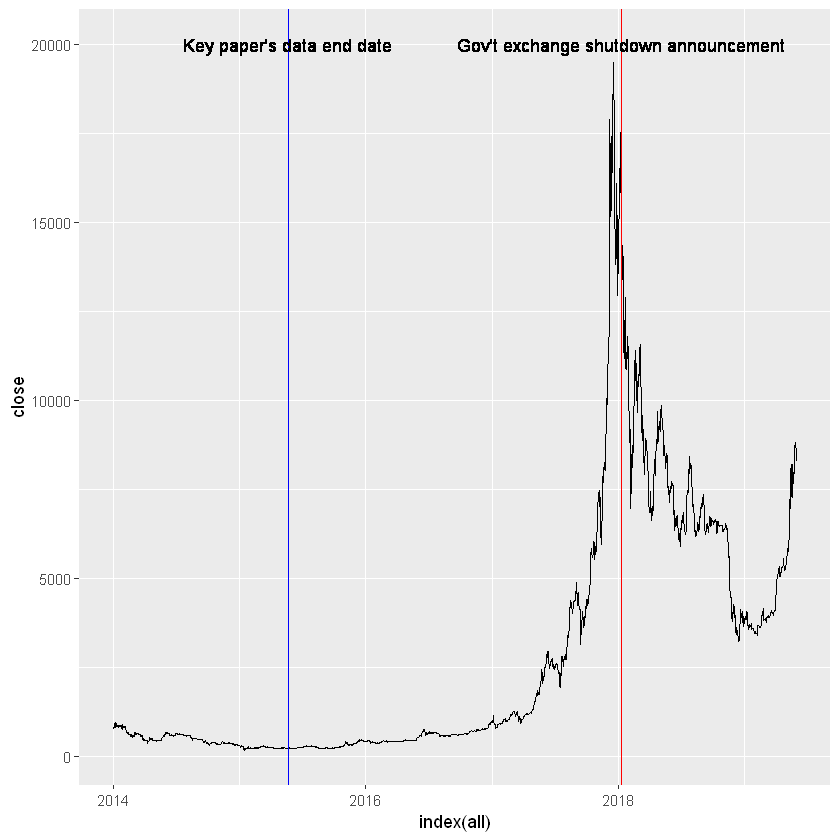

In [77]:
# crash_geom <- ggplot(data=all, aes(x=index(all), y=close)) + geom_vline(xintercept=crash_date, color='red') + geom_text(aes(x=crash_date, label="Exchange shutdown announcement "))
# keypaper_date_geom <- ggplot(data=all, aes(x=index(all), y=close)) + geom_vline(xintercept=keypaper_date, color='blue') + geom_text(aes(x=keypaper_date, label="Key paper's data end date"))

# How do I plot volume & close price on the same graph? 

btc_close_plot <- ggplot(data=all, aes(x=index(all), y=close)) + geom_line() + 
geom_vline(xintercept=crash_date, color='red') + geom_text(aes(x=crash_date, label="Gov't exchange shutdown announcement", y=20000)) + 
geom_vline(xintercept=keypaper_date, color='blue') + geom_text(aes(x=keypaper_date, label="Key paper's data end date", y=20000))

btc_close_plot

In [78]:
head(all)

            close  vol_usd  mktcap_usd  vol_btc mktcap_btc fed_rate gold_usd
2014-01-01 771.40 22489400  9403308145 29154.01   12189925     0.07  1204.50
2014-01-02 802.39 38489500  9781073921 47968.57   12189925     0.07  1225.00
2014-01-03 818.72 37810100  9980135396 46181.97   12189925     0.07  1234.50
2014-01-04 859.51 38005000 10477362437 44217.05   12189925     0.07  1234.50
2014-01-05 933.53 72898496 11379660685 78089.08   12189925     0.07  1234.50
2014-01-06 953.29 85565696 11620533603 89758.31   12189925     0.07  1246.25
             kospi ex_rate
2014-01-01 2011.34  1055.3
2014-01-02 1967.19  1055.3
2014-01-03 1946.14  1050.4
2014-01-04 1946.14  1050.4
2014-01-05 1946.14  1050.4
2014-01-06 1953.28  1054.1

In [79]:
all$rate_btc <- diff(log(all$close)*100, lag=1)
all$rate_vol_btc <- diff(log(all$vol_btc)*100, lag=1)
all$rate_gold_usd <- diff(log(all$gold_usd)*100, lag=1)
all$rate_kospi <- diff(log(all$kospi)*100, lag=1)
all$rate_ex_rate <- diff(log(all$ex_rate)*100, lag=1)

all <- all[-1,]

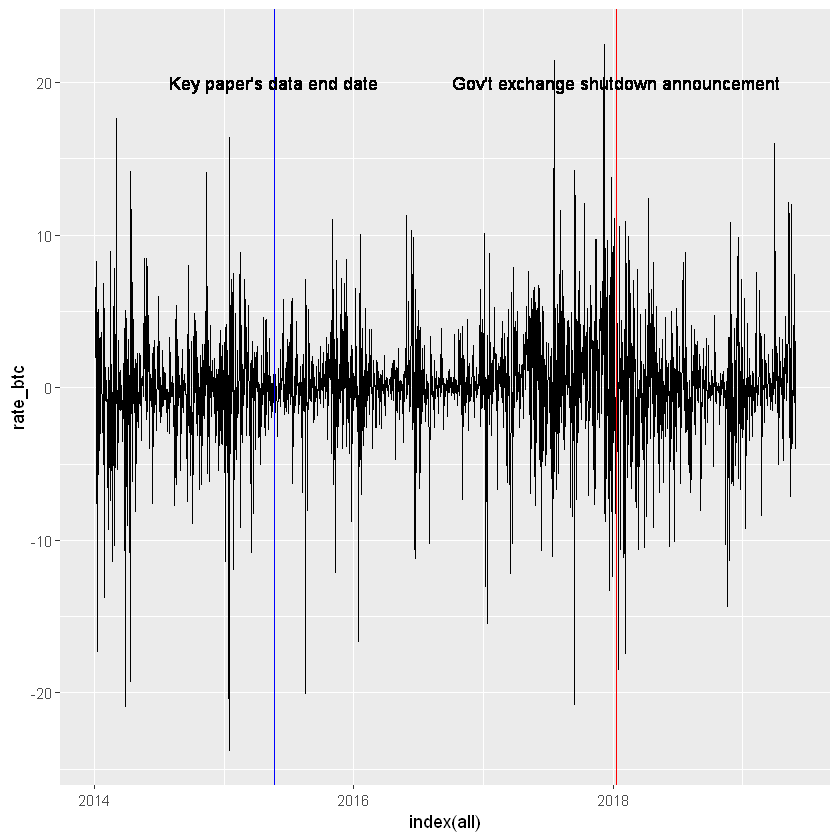

In [84]:
rate_btc_plot <- ggplot(data=all, aes(x=index(all), y=rate_btc)) + geom_line() + 
geom_vline(xintercept=crash_date, color='red') + geom_text(aes(x=crash_date, label="Gov't exchange shutdown announcement", y=20)) + 
geom_vline(xintercept=keypaper_date, color='blue') + geom_text(aes(x=keypaper_date, label="Key paper's data end date", y=20))

rate_btc_plot

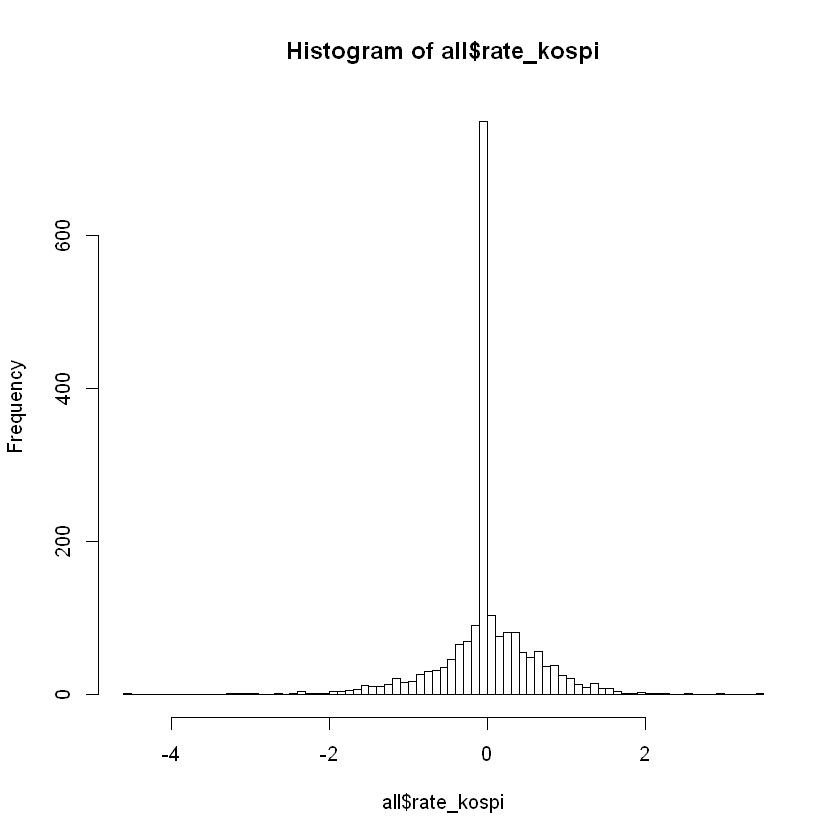

In [113]:
hist(all$rate_kospi, breaks=100)

In [114]:
describe(all$rate_kospi)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,1,1976,0.000759171,0.6187916,0,0.02108207,0.2626495,-4.541103,3.472777,8.01388,-0.612182,5.167789,0.01392037


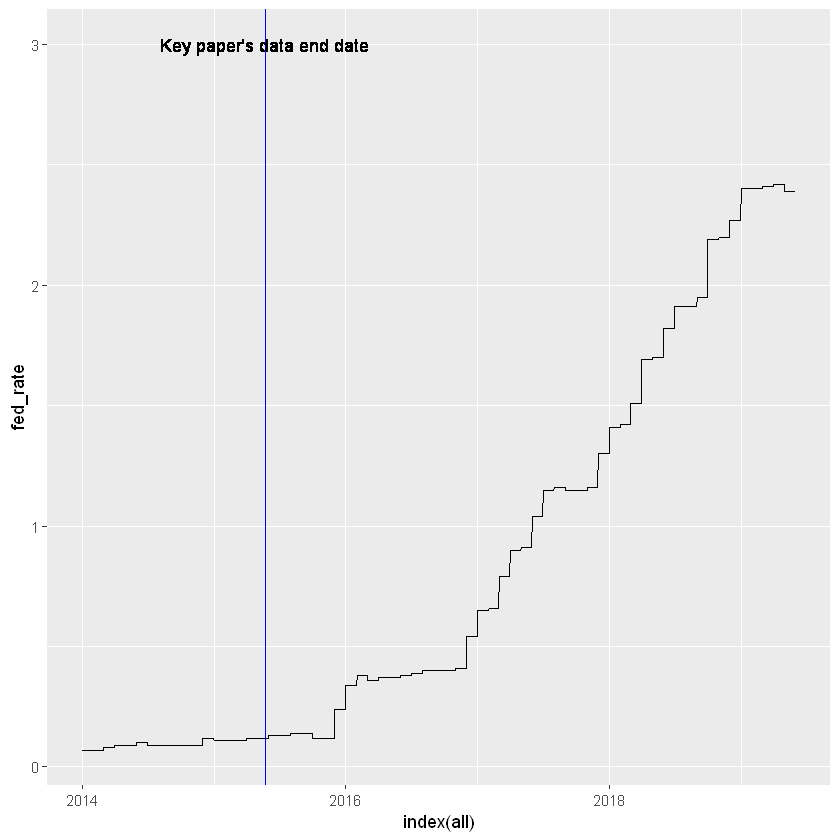

In [103]:
ggplot(data=all, aes(x=index(all), y=fed_rate)) + geom_line() + 
geom_vline(xintercept=keypaper_date, color='blue') + geom_text(aes(x=keypaper_date, label="Key paper's data end date", y=3))

# 2. Check stationarity - unit root test

Using ADF(Augmented Dickey-Fuller test)

H0: B = 1 (unit root)

H1: B < 1  

### 1. Original price data - expected to be non-stationary

In [85]:
adf.test(matrix(all$close), nlag=5)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 -0.476   0.507
[2,]   1 -0.619   0.458
[3,]   2 -0.559   0.479
[4,]   3 -0.528   0.490
[5,]   4 -0.418   0.524
Type 2: with drift no trend 
     lag   ADF p.value
[1,]   0 -1.17   0.641
[2,]   1 -1.31   0.591
[3,]   2 -1.25   0.613
[4,]   3 -1.21   0.626
[5,]   4 -1.11   0.665
Type 3: with drift and trend 
     lag   ADF p.value
[1,]   0 -2.23   0.481
[2,]   1 -2.39   0.412
[3,]   2 -2.32   0.439
[4,]   3 -2.30   0.451
[5,]   4 -2.18   0.499
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


As expected, we cannot reject H0: there exist a unit root 

Therefore the original price data is non-stationary. 

It is unnecessary to perform this on hourly/before/after data

### 2. log-log differenced price data 

In [86]:
adf.test(matrix(all$rate_btc), nlag=5)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag   ADF p.value
[1,]   0 -44.5    0.01
[2,]   1 -32.5    0.01
[3,]   2 -25.2    0.01
[4,]   3 -22.4    0.01
[5,]   4 -19.7    0.01
Type 2: with drift no trend 
     lag   ADF p.value
[1,]   0 -44.5    0.01
[2,]   1 -32.5    0.01
[3,]   2 -25.3    0.01
[4,]   3 -22.5    0.01
[5,]   4 -19.7    0.01
Type 3: with drift and trend 
     lag   ADF p.value
[1,]   0 -44.5    0.01
[2,]   1 -32.6    0.01
[3,]   2 -25.3    0.01
[4,]   3 -22.5    0.01
[5,]   4 -19.8    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 
